# Neural Networks: Part 2 - Model

In [1]:
import torch
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

## Classifier Model

Restart your kernel, so nothing from above carries over.

First, go look at `model/model.py`. The model there should be familiar to you, it is the regression model from the prior lab. It has been updated to be flexibly defined according to the values we pass it.

In [2]:
# this is a relative import, it looks in the directory 'model', then looks in the .py script 'networks' for our class
from model.networks import FullyConnectedNetwork

# instantiate a model
model = FullyConnectedNetwork(17,64)

# confirm it has been made to your specifications
model

FullyConnectedNetwork(
  (linear1): Linear(in_features=17, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

We can continue to customize our network as we go along. However, the current model produces an output designed for regression... how do we modify it to be used for classification?

- The model needs to produce a certain size of outputs. For a binary classification task, a single value, and for multi-class tasks, one value per class. 
- The model's output needs to be transformed to be in the range of 0 to 1.

Make your modifications now.

In [3]:
# here is my model I made
from model.networks_Solution import FCNClassifier

model = FCNClassifier(17, 64, 1)
model

FCNClassifier(
  (linear1): Linear(in_features=17, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

### Train

Let's put it all together and train a classifier on your processed dataset, using your very own dataloader

In [4]:
from model.dataloader_Solution import CustomDataloader

# load data
data_dict = torch.load('data/wages_processed.pt')

# instantiate your dataloaders
train_dataloader = CustomDataloader(data_dict['x_train'],data_dict['y_train'], batch_size = 8, randomize=True)
val_dataloader = CustomDataloader(data_dict['x_val'],data_dict['y_val'], batch_size = 64)
test_dataloader = CustomDataloader(data_dict['x_test'],data_dict['y_test'], batch_size = 64)

I've put in an example way to set up your training loop, adapt it accordingly to your own dataloader and fill in the remaining code

In [5]:
# instantiate your model with the correct inputs and outputs, and a reasonable hidden dim
model = FCNClassifier(17, 256, 1)

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# log your losses
train_losses = []
val_losses = []

# define how many updates to your model
epochs = 100

# define your loss function for a binary classification class
# this is a binary cross entropy loss function, and it expects data in the range 0-1
loss_fn = torch.nn.BCELoss()

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    for _ in range(train_dataloader.num_batches_per_epoch):
        # training data forward pass
        optimizer.zero_grad()
        train_batch = train_dataloader.fetch_batch()
        yhat = model(train_batch['x_batch'])
        train_loss = loss_fn(yhat, train_batch['y_batch'])

        # training data backward pass
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.detach().numpy())
    train_losses.append(np.mean(losses))

    
    losses = []
    for _ in range(val_dataloader.num_batches_per_epoch):
        # validation data forward pass only
        val_batch = val_dataloader.fetch_batch()
        yhat = model(val_batch['x_batch'])
        val_loss = loss_fn(yhat, val_batch['y_batch'])
        losses.append(val_loss.detach().numpy())
    val_losses.append(np.mean(losses))

/Users/astrini/Documents/ECEGR4750/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


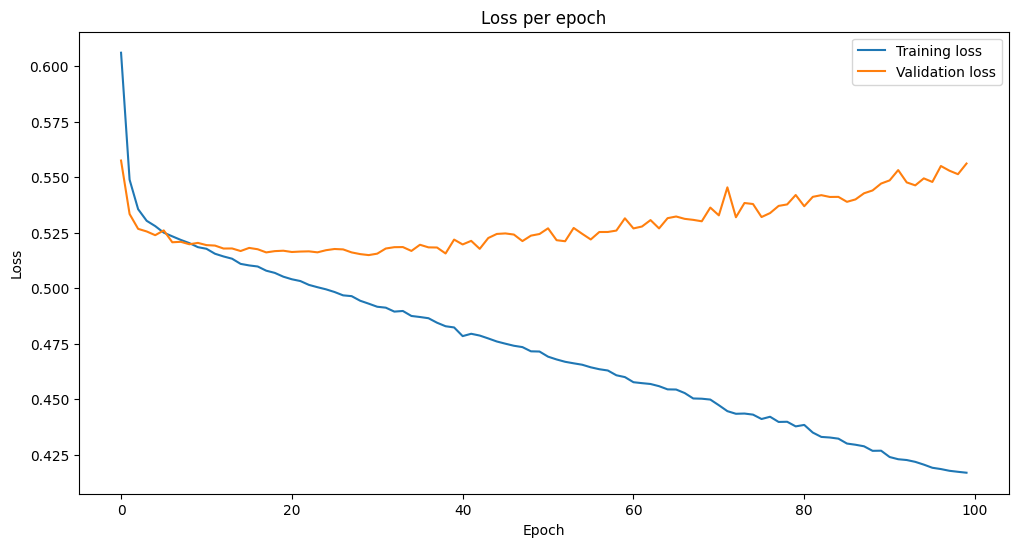

In [6]:
import matplotlib.pyplot as plt

plt.figure(0, figsize = (12,6))
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Training loss","Validation loss"])

How to interpret these loss values? What would be the loss if we randomly chose 1s or 0s? Establish what your random baseline loss is, and see if you are beating it.

- answer: a random classifier will have about 0.69 BCE loss. Values below that are doing better than chance.

Once you are satisfied with your classifier, don't forget to check how you do on your test data

In [13]:
# test data performance

test_losses = []
for _ in range(test_dataloader.num_batches_per_epoch):
    test_batch = test_dataloader.fetch_batch()
    yhat = model(test_batch['x_batch'])
    test_loss = loss_fn(yhat, test_batch['y_batch'])
    test_losses.append(test_loss.detach().numpy())
mean_test_losses = np.mean(test_losses)
print(f'Average loss on test data is {mean_test_losses}')

Average loss on test data is 0.6228693723678589
